# Static Stack Usage Survey

Here are the results of my static analysis of popular open source applications' stack memory usage. This notebook is designed to process CSV files generated by [EscapeAnalysisTool](https://github.com/bencole12345/EscapeAnalysisTool).

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Set up the theme when working locally
try:
    from jupyterthemes import jtplot
#     jtplot.style()
except:
    pass

data_dir = Path('data')

### Data Processing

There's not a lot of special stuff happening. The only interesting part is that I filter out any rows that don't contain any allocations (explained later on).

The data we're working contains counts and sizes of `alloca()` calls, aggregated to function stack frames. I decided against working with individual static calls because multiple separate stack allocations within the same portion of a function would likely be rolled into a single allocation in the function's prolog as a compiler optimisation.

In [2]:
# CSV files we will be analysing
grep_csv = data_dir / 'grep_analysis.csv'
ocamlrun_csv = data_dir / 'ocamlrun.csv'

# Loaded dataframes
grep_data = pd.read_csv(grep_csv.resolve(), sep=';')
ocamlrun_data = pd.read_csv(ocamlrun_csv.resolve(), sep=';')


def filter_empty_stack_frames(df):
    """Remove functions that don't make any stack allocations."""
    
    non_zero_indices = df["NumStackAllocations"] > 0
    filtered = df[non_zero_indices]
    return filtered.reset_index(drop=True)


# Filter out empty rows
grep_data_no_empty_frames = filter_empty_stack_frames(grep_data)
ocamlrun_data_no_empty_frames = filter_empty_stack_frames(ocamlrun_data)

### Graph Plotting and Statistics Functions

These are just functions that I'll use later on for plotting histograms/CDFs and outputting statistics about the data.

In [3]:
def plot_stack_allocation_histograms(df):
    """Plots linear and log scale histograms of stack allocations."""
    
    def compute_log_bins(data, n_bin_boundaries):
        """Computes bins to use for exponentially-distributed data."""
        
        _min = np.min(data)
        _max = np.max(data)
        
        log_min = np.log(_min)
        log_max = np.log(_max)
        
        log_bins = np.linspace(log_min, log_max, num=n_bin_boundaries)
        bins = np.exp(log_bins)
        return bins
        
    total_allocations = df["TotalAllocatedStackMemory"]
    escaping_only = df["TotalEscapingAllocatedStackMemory"]
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,6))
    
    # =========================================================
    # Normal scale
    
    _, bins, _ = ax1.hist([total_allocations, escaping_only],
             label=["All allocations", "Escaping allocations"])
    ax1.legend()
    ax1.set_title("Function stack allocation amounts histogram")
    ax1.set(xlabel="Size (Bytes)")
    ax1.set(ylabel="Number of functions")
    ax1.set_xlim(0, bins[-1])
    
    # ========================================================
    # Log scale
    
    # Bump 0-size allocations up to 1 to avoid computing log(0)
    total_allocations = np.clip(total_allocations, 1, None)
    
    # Compute the bins we need (they're linearly distributed in LOG SPACE)
    num_bin_boundaries = len(bins)
    bins = compute_log_bins(total_allocations, num_bin_boundaries)
    
    # Do the plot
    ax2.hist([total_allocations, escaping_only],
            bins=bins,
            label=["All allocations", "Escaping allocations"])
    ax2.legend()
    ax2.set_xscale('log')
    ax2.set_title("Function stack allocation amounts histogram (log scale)")
    ax2.set(xlabel="Size (Bytes, logarithmic)")
    ax2.set(ylabel="Number of functions")
    
    plt.show()
    
    
def plot_stack_allocation_CDFs(df):
    """Plots linear and log scale CDFs of stack allocations."""
    
    def get_cumulative_histogram(series):
        """Computes the cumulative histogram of data."""
        N = series.count()
        x = series_sorted = np.sort(series)
        y = np.arange(N) / N
        return x, y
    
    total_allocations = df["TotalAllocatedStackMemory"]
    escaping_only = df["TotalEscapingAllocatedStackMemory"]
    
    x_total, y = get_cumulative_histogram(total_allocations)
    x_escaping = np.sort(escaping_only)
    max_val = x_total[-1]
    x_total = np.append(x_total, max_val)
    x_escaping = np.append(x_escaping, max_val)
    y = np.append(y, 1)
    
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 6))
    
    linear_plot = ax1.plot(x_total, 100*y, x_escaping, 100*y)
    ax1.set_title("Function stack allocation amounts CDF")
    ax1.set(xlabel="Size (Bytes)")
    ax1.set(ylabel="Percentage (%)")
    ax1.legend(["All allocations", "Escaping allocations"])
    
    log_plot = ax2.plot(x_total, 100*y, x_escaping, 100*y)
    ax2.set_title("Function stack allocation amounts CDF (log scale)")
    ax2.set(xlabel="Size (Bytes, logarithmic)")
    ax2.set(ylabel="Percentage (%)")
    ax2.set_xscale('log')
    ax2.legend(["All allocations", "Escaping allocations"])
    
    fig.show()
    

def print_statistics(df):
    """Prints some statistics about the data."""
    
    total_allocations = df["TotalAllocatedStackMemory"]
    escaping_only = df["TotalEscapingAllocatedStackMemory"]
    
    print(
        f"All allocations:\n"
        f"      Mean: {np.mean(total_allocations):.1f} bytes\n"
        f"    Median: {np.median(total_allocations)} bytes\n"
        f"Escaping allocations only:\n"
        f"      Mean: {np.mean(escaping_only):.1f} bytes\n"
        f"    Median: {np.median(escaping_only)} bytes"
    )

# Analysis

## Tool 1: Grep

The first tool to analyse is Grep, the Unix command line tool for searching files for lines matching a passed regex.

Here's a snippet of some of the data. I decompiled the binary included with my Ubuntu 20.04 install, which is why the function names are meaningless. Soon I plan to redo this with a proper compilation of the source code, rather than just using a decompiled binary.

### Data Overview
Here's what the data we're working with actually looks like:

In [4]:
grep_data

,FileName,FunctionName,NumStackAllocations,NumEscapingStackAllocations,TotalAllocatedStackMemory,TotalEscapingAllocatedStackMemory
0,test,function_4000,0,0,0,0
1,test,function_4003,1,0,8,0
2,test,function_46a0,0,0,0,0
3,test,function_46a3,0,0,0,0
4,test,function_46b0,0,0,0,0
...,...,...,...,...,...,...
766,test,__decompiler_undefined_function_3,0,0,0,0
767,test,__decompiler_undefined_function_5,0,0,0,0
768,test,__decompiler_undefined_function_7,0,0,0,0
769,test,__decompiler_undefined_function_8,0,0,0,0


Unfortunately, because I used a decompiler to get the LLVM IR code, there are quite a few functions with names like `__decompiler_undefined_function_8`. I suspect that these might be forward-declared functions imported from header files that will be linked in at runtime, but I'll have to investigate further to be sure. These functions have no implementation, only type signatures. As a result, they don't make any stack allocations, which seems highly unrealistic. For this reason, I dropped all rows for functions whose stack frames are of zero size.

In [5]:
grep_data_no_empty_frames

,FileName,FunctionName,NumStackAllocations,NumEscapingStackAllocations,TotalAllocatedStackMemory,TotalEscapingAllocatedStackMemory
0,test,function_4003,1,0,8,0
1,test,function_4e13,151,10,1127,61
2,test,function_64d3,1,1,8,8
3,test,function_6573,1,0,8,0
4,test,function_6623,79,3,604,24
...,...,...,...,...,...,...
153,test,function_25a33,1,0,8,0
154,test,function_25b33,1,0,8,0
155,test,function_25bb3,1,0,8,0
156,test,function_25c93,9,1,72,8


In [6]:
print_statistics(grep_data_no_empty_frames)

All allocations:
      Mean: 257.3 bytes
    Median: 58.5 bytes
Escaping allocations only:
      Mean: 5.7 bytes
    Median: 0.0 bytes


### Graphs

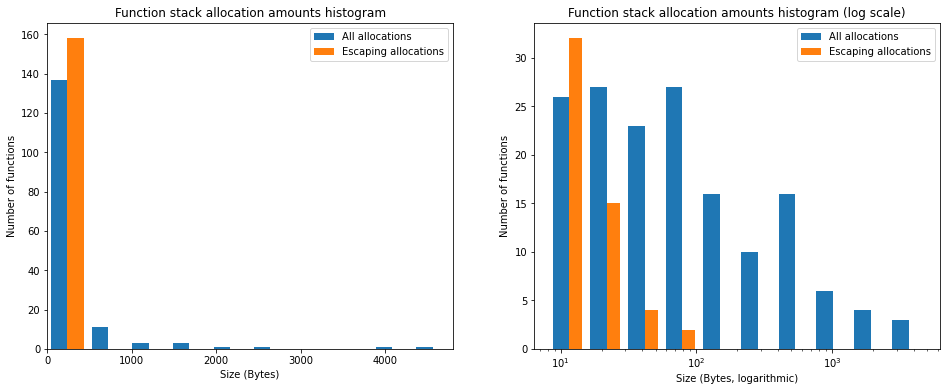

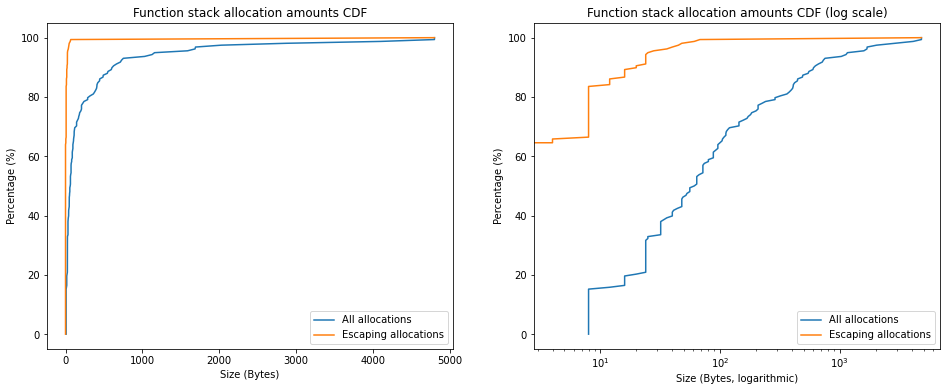

In [7]:
plot_stack_allocation_histograms(grep_data_no_empty_frames)
plot_stack_allocation_CDFs(grep_data_no_empty_frames)

### Observations

- The sizes of allocations span a large range, varying by at least three orders of magnitude.

- The majority of allocations are small, but there is a long tail. This is why there's such a huge difference between the median (58.5 bytes) and mean (257.3 bytes) stack frame sizes.

- The majority of functions make no unsafe allocations, though according to the tool, nearly 40% do (after filtering out the empty stack frames). It's worth noting that the problem of determining whether a value escapes is undecideable, so LLVM's capture tracking analysis necessarily must be an approximation with some false positives.

- Some buckets report having more unsafe allocations than total allocations. This is because the tool counts allocations at the function level, meaning that this is a histogram of functions' sizes rather than the sizes of all calls to `alloca()`. Some of these escaping calls will therefore contribute to a lower value bucket for the 'escaping allocations' histogram than the bucket they contribute to for the 'all allocations' histogram. It wouldn't make sense for a function to allocate more possibly-escaping memory than it allocates in total.

## Program 2: OCaml Runtime
Next up is OCaml's runtime/interpreter, `ocamlrun`.

This time I actually managed to compile it properly from source to LLVM IR. I used [GLLVM](https://github.com/SRI-CSL/gllvm), a thin layer on top of Clang that intercepts calls to the environment variable `CC` to force Clang to emit LLVM bitcode rather than x86 assembly. I then ran `llvm-dis` on the generated `.bc` file to yield a `.ll` file, which I then fed to EscapeAnalysisTool to produce this CSV file.

### The Data
Surprisingly, this data also contained a lot of empty functions.

TODO: Find out what's going on here!

In [8]:
ocamlrun_data

,FileName,FunctionName,NumStackAllocations,NumEscapingStackAllocations,TotalAllocatedStackMemory,TotalEscapingAllocatedStackMemory
0,llvm-link,caml_init_stack,0,0,0,0
1,llvm-link,llvm.dbg.value,0,0,0,0
2,llvm-link,caml_realloc_stack,0,0,0,0
3,llvm-link,llvm.memmove.p0i8.p0i8.i64,0,0,0,0
4,llvm-link,caml_ensure_stack_capacity,0,0,0,0
...,...,...,...,...,...,...
1001,llvm-link,caml_debug_info_available,0,0,0,0
1002,llvm-link,caml_debug_info_status,0,0,0,0
1003,llvm-link,caml_debuginfo_location,0,0,0,0
1004,llvm-link,caml_debuginfo_extract,0,0,0,0


In [9]:
ocamlrun_data_no_empty_frames

,FileName,FunctionName,NumStackAllocations,NumEscapingStackAllocations,TotalAllocatedStackMemory,TotalEscapingAllocatedStackMemory
0,llvm-link,caml_stat_strconcat,1,1,24,24
1,llvm-link,caml_alloc_array,3,3,80,80
2,llvm-link,caml_copy_string_array,3,3,80,80
3,llvm-link,caml_alloc_some,2,2,72,72
4,llvm-link,caml_raise_with_arg,5,5,152,152
...,...,...,...,...,...,...
177,llvm-link,caml_add_debug_info,2,2,72,72
178,llvm-link,process_debug_events,6,6,160,160
179,llvm-link,caml_remove_debug_info,3,3,80,80
180,llvm-link,caml_init_debug_info,2,2,72,72


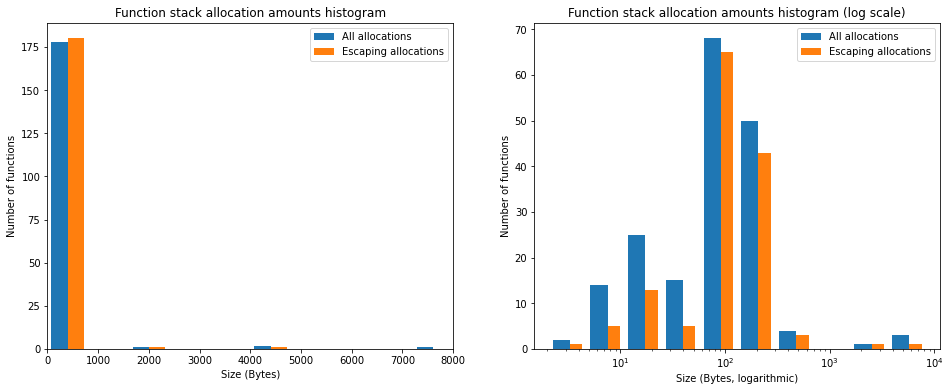

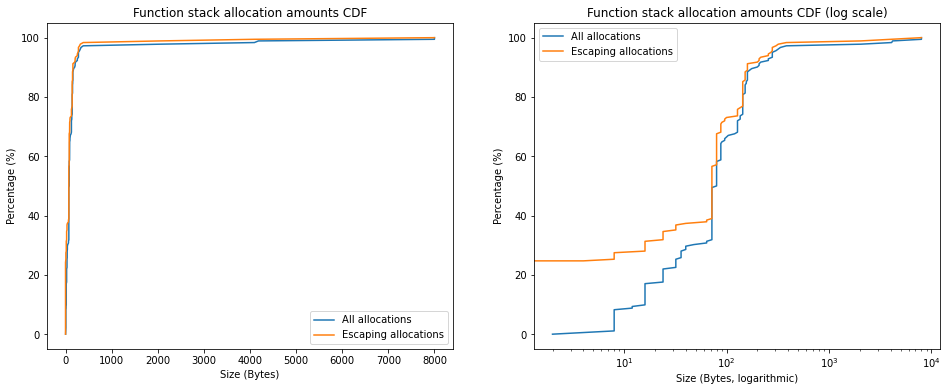

In [10]:
plot_stack_allocation_histograms(ocamlrun_data_no_empty_frames)
plot_stack_allocation_CDFs(ocamlrun_data_no_empty_frames)

### Analysis

There are two main observations that I made here:

- The allocations on average tend to be much larger than those of Grep. Presumably this is because the runtime needs to allocate large data structures to support the program.

- This time the majority of stack-allocated memory appears to be escaping. Perhaps this is because the runtime makes use of lots of closures, which the analysis tool detects as possibly-escaping.

**TODO: I'm not sure how much to trust this analysis until I can explain why the majority of functions seemed to have empty stack frames.**

# Things left to do

- Compile Grep properly and re-run EscapeAnalysisTool
- Analyse Chromium source code
- Analyse LLVM source code

I also intend to do some dynamic analysis to get a feel for *stack throughput*, since right now we don't know how much each of these functions are used. The functions with the large escaping allocations don't really matter if they are only called once.